In [1]:
### ipyleaflet required to run the map codes in data exploration
# !pip install ipyleaflet

# Use these commands in terminal
### Install ipyleaflet:                conda install -c conda-forge ipyleaflet
### Install Node.js:                   conda install -c anaconda nodejs
### Install the JupyterLab extension:  jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-leaflet

# RUN THE FOLLOWING COMMAND IN JUPYTER TERMINAL
# jupyter labextension develop . --overwrite

In [2]:
### Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors

import ipyleaflet as ipy
# from synapse.ml.isolationforest.IsolationForest import IsolationForest

from pyspark import SparkContext
import pyspark.sql.functions as F
import pyspark.ml.functions as M
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import Window as W
from pyspark.sql.types import *
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Isolation Forest
from pyspark.ml.util import JavaMLReadable, JavaMLWritable
from synapse.ml.core.platform import running_on_synapse_internal
# from synapse.ml.core.serialize.java_params_patch import *
from pyspark.ml.wrapper import JavaTransformer, JavaEstimator, JavaModel
from pyspark.ml.evaluation import JavaEvaluator
from pyspark.ml.common import inherit_doc
# from synapse.ml.core.schema.Utils import *
from pyspark.ml.param import TypeConverters
# from synapse.ml.core.schema.TypeConversionUtils import generateTypeConverter, complexTypeConverter
# from synapse.ml.isolationforest.IsolationForestModel import IsolationForestModel
# from synapse.ml.isolationforest import *

Matplotlib created a temporary cache directory at /tmp/matplotlib-vg6a0fuj because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
### Notes from prof's example notebook
# #Make sure you allocate enough memory per core. if you chose 3 cores you should select 6GB in your per Node setting. (presumably 2GB per core)

### For server
# 32 nodes
# 64g

## Start Spark context
total_nodes = 10
memory_per_node = 100

driver_memory = f"{memory_per_node}g"
executor_memory = f"{int(memory_per_node/total_nodes)}g"
n_executors = total_nodes - 1
print(f"Driver memory: {driver_memory}\nExecutor memory: {executor_memory}\nNumber of executors: {n_executors}\n")
try:
    print("Initializing SparkContext")
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config('spark.local.dir', "test_dir/") \
                             .config("spark.driver.maxResultSize", "16g") \
                             .config("spark.executor.instances", n_executors) \
                             .getOrCreate()
    
                             # .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.4") \
                             # .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
except:
    print("Starting new SparkContext")
    sc.stop()
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config('spark.local.dir', "test_dir/") \
                             .config("spark.driver.maxResultSize", "16g") \
                             .config("spark.executor.instances", n_executors) \
                             .appName("MyApp") \
                             .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.4") \
                             .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
                             .getOrCreate()
print(sc)

# Start SQL Context
sqlContext = SQLContext(sc)

# Add sc parameters
sc.getActiveSession()
# sc.builder.appName("Read CSV").getOrCreate()
# sc.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

Driver memory: 100g
Executor memory: 10g
Number of executors: 9

Initializing SparkContext


/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
%%time
### Load datasets
df_type = 30

### Open the preprocessed dataset
################################################################################### Ensure that the path here matches the path of the file from preprocessing
df = sqlContext.read.load("preprocessed_df_single_3/preprocessed_df_1.parquet")
# df_count = df.count()

# metadata
meta_filename = "metadata_preprocessed.csv"
df_meta = sc.read.csv(meta_filename, inferSchema=True, header=True)
# df_meta_count = df_meta.count()

### Comments
# print(f"30min dataset has {df_count} rows")
# df.show(3)
# print(f"Meta dataset has {df_meta_count} rows")
# df_meta.show(3)
# print("/nTable schemas/n")
# print(f"Schema of the {df_type} min time series data table") ###
# df.printSchema()
# print("Schema of the metadata table")
# df_meta.printSchema()

### Since metadata table is so small, convert to Pandas
df_meta = df_meta.toPandas()

CPU times: user 80.5 ms, sys: 8.9 ms, total: 89.4 ms
Wall time: 3.47 s


In [5]:
%%time
kwp_text = "2.28 <= kwp <= 3.42"
print(df.count(), "rows in the dataset")
df.show(1, vertical=True)

28087986 rows in the dataset
-RECORD 0-------------------------------
 id              | 0                    
 ss_id           | 2405                 
 stamp_date      | 2012-01-21           
 power_kW_values | [0.0, 0.0, 0.0, 0... 
 coefficients    | [0.49785779737625... 
 reconstructions | [0.00410907621307... 
 recon_PC        | [-0.4178259582696... 
 recon_PC1       | -0.41782595826965074 
 recon_PC2       | -0.02458836598737569 
 power_PC        | [-0.0129104585327... 
 power_PC1       | -0.01291045853276512 
 power_PC2       | 0.002746521891096... 
only showing top 1 row

CPU times: user 6 ms, sys: 2.79 ms, total: 8.79 ms
Wall time: 2min 47s


# PCA Analysis for Anomaly Detection
This analysis will be performed on the principal components obtained from reconstructions on the filtered data where 2.28 <= kwp <= 3.42

In [6]:
%%time
### Plot the data along the top two principal components (use a log scale on the axes)
pd_df = df.select("recon_PC1","recon_PC2").toPandas()

CPU times: user 48.4 s, sys: 3.19 s, total: 51.6 s
Wall time: 56 s


CPU times: user 1.78 s, sys: 117 ms, total: 1.89 s
Wall time: 1.96 s


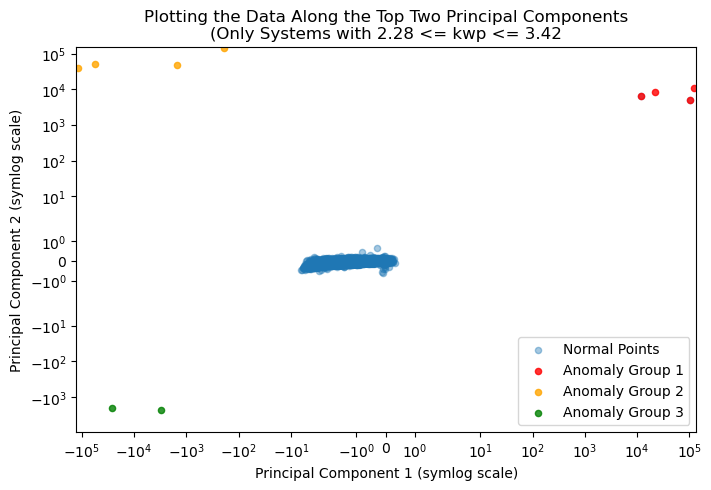

In [7]:
%%time
### Plot the data along the top two principal components (use a log scale on the axes)
fig,ax = plt.subplots(1,1, figsize=(8,5))
# pd_df.plot.scatter("recon_PC1", "recon_PC2", alpha=0.4, label="Normal Points", ax=ax)
pd_df.sample(frac=0.2).plot.scatter("recon_PC1", "recon_PC2", alpha=0.4, label="Normal Points", ax=ax)
pd_df[pd_df["recon_PC1"]>1000].plot.scatter("recon_PC1", "recon_PC2", 
                                            color="r", alpha=0.8, label="Anomaly Group 1", ax=ax)
pd_df[(pd_df["recon_PC1"]<-100) & (pd_df["recon_PC2"]>1000)].plot.scatter("recon_PC1", "recon_PC2", 
                                                                          color="orange", alpha=0.8, 
                                                                          label="Anomaly Group 2", ax=ax)
pd_df[(pd_df["recon_PC1"]<-100) & (pd_df["recon_PC2"]<-100)].plot.scatter("recon_PC1", "recon_PC2", 
                                                                          color="green", alpha=0.8, 
                                                                          label="Anomaly Group 3", ax=ax)
plt.xlabel("Principal Component 1 (symlog scale)")
plt.ylabel("Principal Component 2 (symlog scale)")
plt.title(f"Plotting the Data Along the Top Two Principal Components\n(Only Systems with {kwp_text}")
plt.xscale("symlog")
plt.yscale("symlog")

Outliers seem present where PC1 > 10^2 (100)

In [8]:
%%time
### Examining the correlation between PC1 and PC2
vecAssembler = VectorAssembler(inputCols=["recon_PC1", "recon_PC2"], outputCol="features")
pearsonCorr = Correlation.corr(vecAssembler.transform(df), "features", "pearson").collect()[0][0]

CPU times: user 7.49 ms, sys: 2.11 ms, total: 9.61 ms
Wall time: 2min 8s


In [9]:
print("Global correlation matrix between PC1 and PC2:\n\n", pearsonCorr.toArray())
print()
print("PC1 and PC2 are not very highly correlated with one another globally")

Global correlation matrix between PC1 and PC2:

 [[ 1.         -0.15381582]
 [-0.15381582  1.        ]]

PC1 and PC2 are not very highly correlated with one another globally


In [10]:
%%time
### Isolate the outlier points
print("Number of major outlier points:", df.where((F.col("recon_PC1") > 100) | (F.col("recon_PC1")<-100)).count())
print()
df.where((F.col("recon_PC1") > 100) | (F.col("recon_PC1")<-100)).select("id", "ss_id", "stamp_date", "recon_PC1", "recon_PC2").show(50)
print()

Number of major outlier points: 10

+------------+-----+----------+-------------------+-------------------+
|          id|ss_id|stamp_date|          recon_PC1|          recon_PC2|
+------------+-----+----------+-------------------+-------------------+
| 34359900110|11166|2017-10-19| 123025.02637079507| 11108.464198530139|
|146029336759| 7635|2017-12-02|-56668.839213105144|  51726.57342267001|
|249108282825| 7635|2017-11-28| 11815.754154115948|    6298.7838960681|
|403727106413| 7635|2017-11-25|-1475.5865940630792|   49155.5583090022|
|438087055175| 3148|2018-11-07|-114966.08781856023|  38637.07072116534|
|489626448788| 7635|2017-11-30|-190.69693162903422| 143950.88123373684|
|678605013184| 7635|2017-11-20|-3087.6842299185228|-2253.2285461694337|
|695784882663| 7635|2017-11-21|   100764.007985186|  4846.949870303924|
|798864097700| 7635|2017-11-26| 21874.764316743822|  8341.350837082959|
|816044242474| 7635|2017-12-07|-26122.909837990628|-2052.0495527738276|
+------------+-----+--------

In [11]:
pca_outliers = df.where((F.col("recon_PC1") > 100) | (F.col("recon_PC1")<-100)) \
                 .toPandas()

# plt.scatter(pca_outliers["PC1"], pca_outliers["PC2"])
# plt.xscale("log")
# plt.yscale("log")
# plt.title("Plotting Data Along the Top 2 Principal Components\n(PC1 > 10, kwp <= 3.42)")
# plt.xlabel("Principal Component 1 (log scale)")
# plt.ylabel("Principal Component 2 (log scale)")

pca_outliers.to_csv("pca_major_outliers.csv", header=True)

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

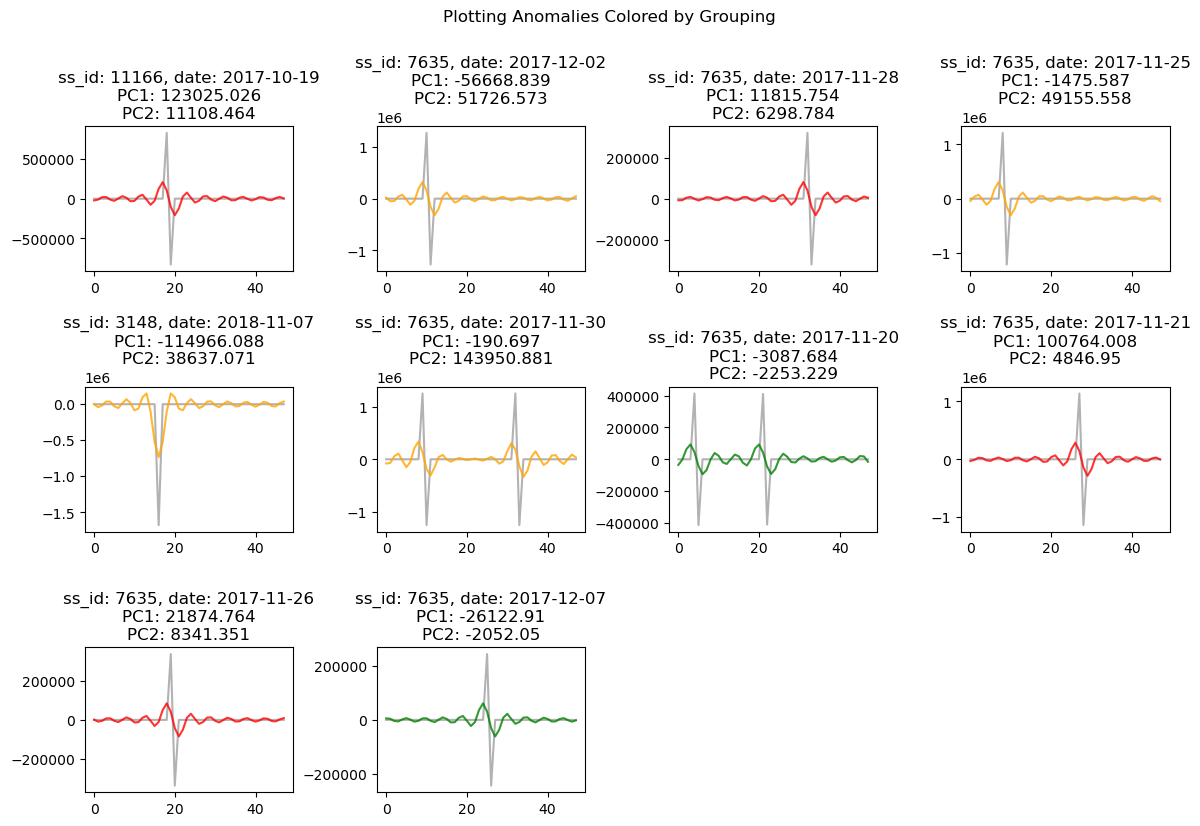

In [20]:
### Plotting the anomaly groupings
cond = pca_outliers["recon_PC1"]>100
pca_outliers[cond]

fig, ax = plt.subplots(3, 4, figsize=(14, 9))
axes = ax.flatten()
for i,row in enumerate(pca_outliers.iterrows()):
    ss_id = row[1][1]
    date = row[1][2]
    recon = row[1][5]
    power = row[1][3]
    pc1 = np.round(row[1][7], 3)
    pc2 = np.round(row[1][8], 3)

    if pc1 > 10:
        color = "r"
    elif pc1 < -10:
        if pc2 > 10:
            color = "orange"
        else:
            color = "g"
    
    x = [i for i in range(0, 48)]
    axes[i].plot(x, power, "k", alpha=0.3)
    axes[i].plot(x, recon, color, alpha=0.8)
    axes[i].set(title=f"ss_id: {ss_id}, date: {date}\nPC1: {pc1}\nPC2: {pc2}")

axes[10].axis("off")
axes[11].axis("off")
plt.suptitle("Plotting Anomalies Colored by Grouping")
plt.subplots_adjust(wspace=0.4, hspace=0.8, top=0.85)
plt.tight_layout


There is no clear pattern which differentiates the anomaly groupings, though they are all consistent with large spikes in power (usually in both the positive and negative directions).

Notably, ss_id 7635 makes up 8/10 of the major anomalies, and they all occur within a short time-span (2017-11-20 to 2017-12-07)

In [21]:
%%time
### Separate out the "non_outliers" and plot them
pca_non_outliers = df.where((F.col("recon_PC1") <= 100) & (F.col("recon_PC1") >= -100)) \
                     .select("id", "ss_id", "stamp_date", "recon_PC1", "recon_PC2") \
                     .toPandas()


CPU times: user 1min 36s, sys: 4.24 s, total: 1min 41s
Wall time: 1min 46s


In [22]:
%%time
## Finding the mean PC vector excluding the outliers
print("Printing Mean values")
# pc1_mean, pc2_mean = pca_non_outliers[["recon_PC1", "recon_PC2"]].agg("mean")
pc1_mean, pc2_mean = df.where((F.col("recon_PC1") <= 100) & (F.col("recon_PC1") >= -100)) \
                       .select(F.avg("recon_PC1"), F.avg("recon_PC2")).collect()[0]


print("Mean of PC1:", pc1_mean)
print("Mean of PC2:", pc2_mean)
# print()

Printing Mean values
Mean of PC1: -1.2105289983704304
Mean of PC2: -0.06401685160313039
CPU times: user 4.84 ms, sys: 1.98 ms, total: 6.82 ms
Wall time: 1min 15s


Text(0, 0.5, 'PC2 (symlog scale)')

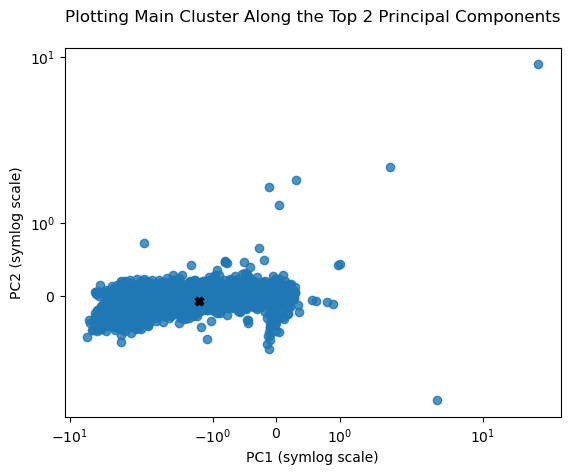

In [23]:
plt.scatter(pca_non_outliers["recon_PC1"], pca_non_outliers["recon_PC2"], alpha=0.8)
plt.scatter(pc1_mean, pc2_mean, marker="X", c="k")
plt.xscale("symlog")
plt.yscale("symlog")
plt.title("Plotting Main Cluster Along the Top 2 Principal Components\n")
plt.xlabel("PC1 (symlog scale)")
plt.ylabel("PC2 (symlog scale)")
# plt.ylim([10**(-9), 100])


In [35]:
### Define functions to visualize curves and plot min/max power generation
def plot_curves(cond, sort_col, suptitle, print_text):
    # df.where(cond & cond_mean).count()
    pc_df = df.where(cond).toPandas()
    print(print_text, len(pc_df))
    
    ind = [int(i) for i in np.linspace(0, len(pc_df)-1, 6)]
    ind
    
    x = [i for i in range(0, 48)]
    
    fig, axes = plt.subplots(2,3, figsize=(15,8))
    for i,ax in zip(ind, axes.flatten()):
        subset = pc_df.sort_values(sort_col).reset_index(drop=True).loc[i, :]  ### Change sort value as needed
        id = subset["id"]
        ss_id = subset["ss_id"]
        date = subset["stamp_date"]
        pc1 = np.round(subset["recon_PC1"], 3)
        pc2 = np.round(subset["recon_PC2"], 3)
        reconstructions, power_kW_values = df.where(F.col("id")==id).select("reconstructions", "power_kW_values").collect()[0]
    
        # Plot the values vs reconstructions
        ax.plot(x, power_kW_values, linestyle="-", c="k", alpha=0.2)
        ax.plot(x, reconstructions, linestyle="-", c="r", alpha=1)
        ax.set(title=f"ss_id: {ss_id}, date: {date}\nPC1: {pc1}\nPC2: {pc2}")
    plt.suptitle(suptitle)
    fig.tight_layout()

    return pc_df

def plot_min_max(pc_df, x_axis, main_scatter_size):
    pc = pc_df[["power_kW_values", x_axis]].reset_index(drop=True)
    pc["max_power"] = pc.loc[:, "power_kW_values"].apply(lambda a: max(map(float, a)) + 0.01)
    pc["min_power"] = pc.loc[:, "power_kW_values"].apply(lambda a: min(map(float, a)) + 0.01)
    pc["min_power_color"] = np.sign(pc["min_power"]-0.01).astype(int).map({0:"k", 1:"r", -1:"orange"})
    pc["size"] = np.sign(pc["min_power"]-0.01).astype(int).map({0:5, 1:5, -1:10})
    pc_zero = pc[pc["min_power"] == 0.01]
    pc_neg = pc[pc["min_power"] < 0.01]
    pc_pos = pc[pc["min_power"] > 0.01]
    
    x = [i for i in np.arange(0, len(pc))]

    print(pc_zero.columns)
    
    fig,ax = plt.subplots(1,1, figsize=(7,4))
    ax1 = plt.scatter(pc[x_axis], pc["max_power"], c="b", s=main_scatter_size)
    ax2 = plt.scatter(pc_zero[x_axis], y=pc_zero["min_power"], c=pc_zero["min_power_color"], s=pc_zero["size"])
    ax3 = plt.scatter(pc_neg[x_axis], y=pc_neg["min_power"], c=pc_neg["min_power_color"], s=pc_neg["size"])
    ax4 = plt.scatter(pc_pos[x_axis], y=pc_pos["min_power"], c=pc_pos["min_power_color"], s=pc_pos["size"])
    plt.legend([ax1, ax2, ax3, ax4], ["Max Power", "Min Power = 0", "Min Power < 0", "Min Power > 0"], 
              loc="upper right", bbox_to_anchor=[1.3, 1.025])
    plt.xlabel(f"{x_axis}")
    plt.ylabel("Power Generation (kW)")
    if x_axis=="recon_PC1":
        plt.title(f"Max and Min Power Generation")
    else:
        plt.title(f"Max and Min Power Generation")
    plt.grid()
    
    print(pc.sort_values(x_axis, ascending=True)["min_power"].value_counts())



### Analyzing Mean PC1 With Increasing PC2

Number of data points: 507693
CPU times: user 17.5 s, sys: 491 ms, total: 18 s
Wall time: 34.2 s


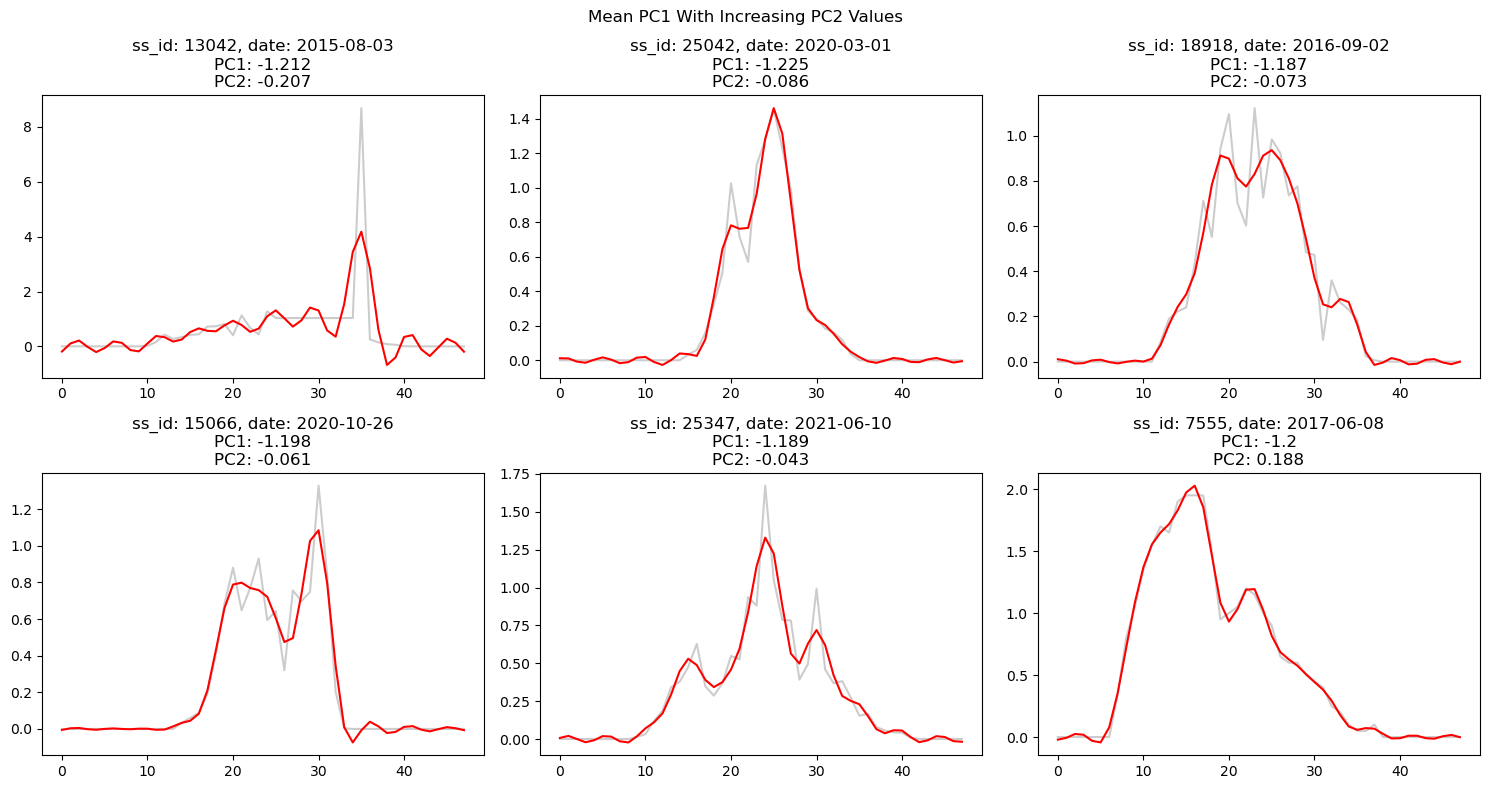

In [45]:
%%time
cutoff = 0.025

# Visualize power generation curves with increasing pc2 values
pc_df = plot_curves(cond = (F.col("recon_PC1") < pc1_mean+cutoff) & (F.col("recon_PC1") > pc1_mean-cutoff), # & (F.col("PC2") < pc2_mean + bound) & (F.col("PC2") > pc2_mean + bound),
                    sort_col = "recon_PC2",
                    suptitle = "Mean PC1 With Increasing PC2 Values",
                    print_text = "Number of data points:")
        

Number of data points extracted 507693
Index(['power_kW_values', 'recon_PC2', 'max_power', 'min_power',
       'min_power_color', 'size'],
      dtype='object')
min_power
0.010000    507689
0.093160         1
0.015500         1
0.110000         1
0.011312         1
Name: count, dtype: int64


(-0.2, 0.2)

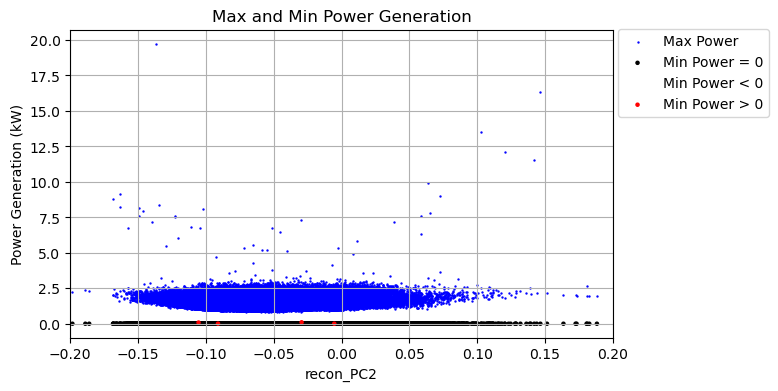

In [46]:
# Plot the maximum and minimum power_kW values for curves where PC1 < -2
print("Number of data points extracted", len(pc_df))
plot_min_max(pc_df,
             x_axis = "recon_PC2",
             main_scatter_size = 0.5)

plt.xlim([-0.2, 0.2])
# plt.savefig("maxmin_power_pc2fixed_log.png")

### Analyzing Low PC2 With Increasing PC1

Number of data points: 349110
CPU times: user 18.4 s, sys: 1.8 s, total: 20.2 s
Wall time: 35 s


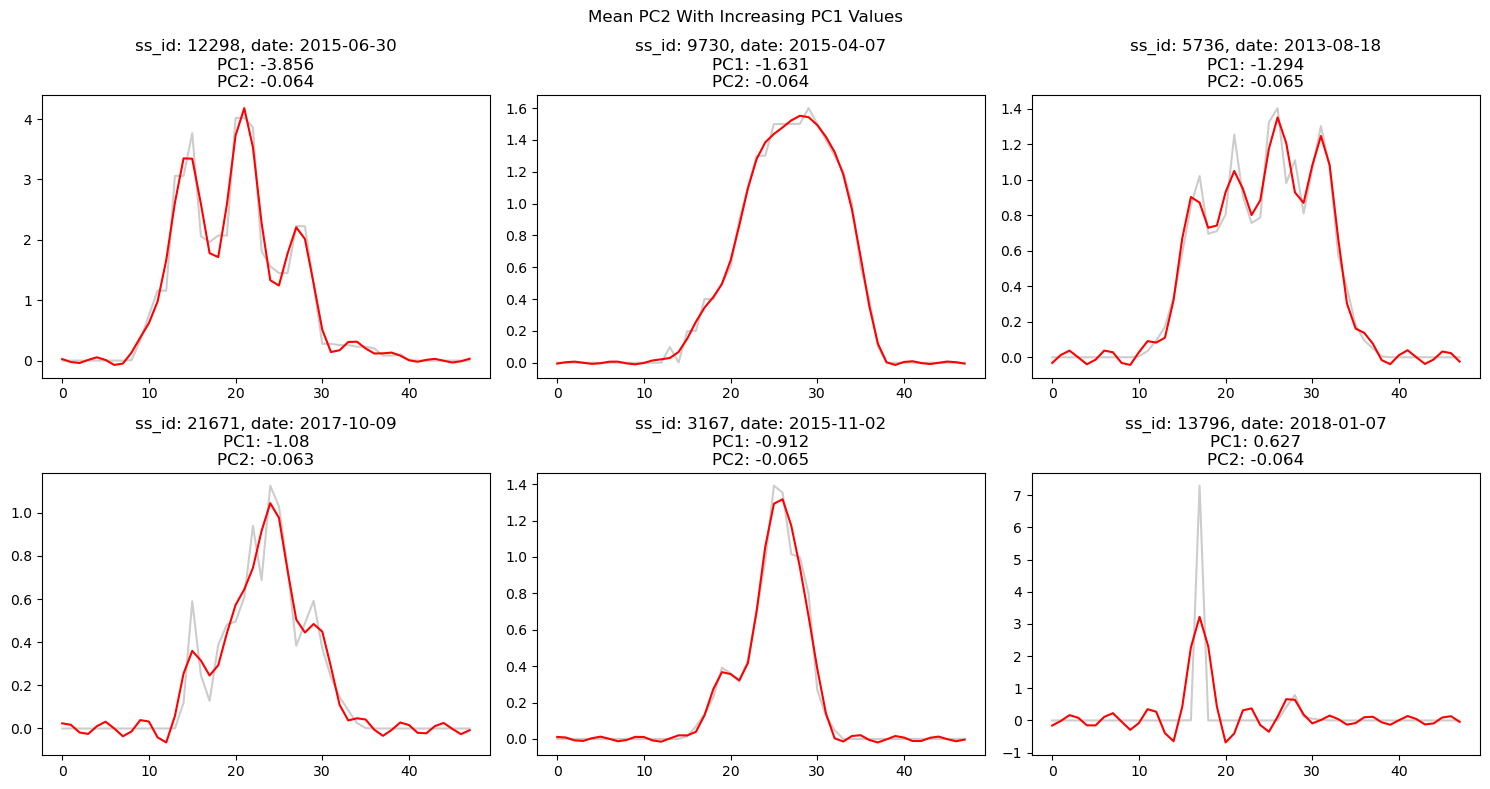

In [38]:
%%time
cutoff = 0.001
# Visualize power generation curves with increasing pc2 values
pc_df = plot_curves(cond = (F.col("recon_PC2") < pc2_mean+cutoff) & (F.col("recon_PC2") > pc2_mean-cutoff), # & (F.col("PC2") < pc2_mean + bound) & (F.col("PC2") > pc2_mean + bound),
                    sort_col = "recon_PC1",
                    suptitle = "Mean PC2 With Increasing PC1 Values",
                    print_text = "Number of data points:")
        

Number of data points extracted 349110
Index(['power_kW_values', 'recon_PC1', 'max_power', 'min_power',
       'min_power_color', 'size'],
      dtype='object')
min_power
0.01000    349105
0.01884         1
0.07084         1
0.04784         1
0.10834         1
0.18534         1
Name: count, dtype: int64


(-4.0, 0.0)

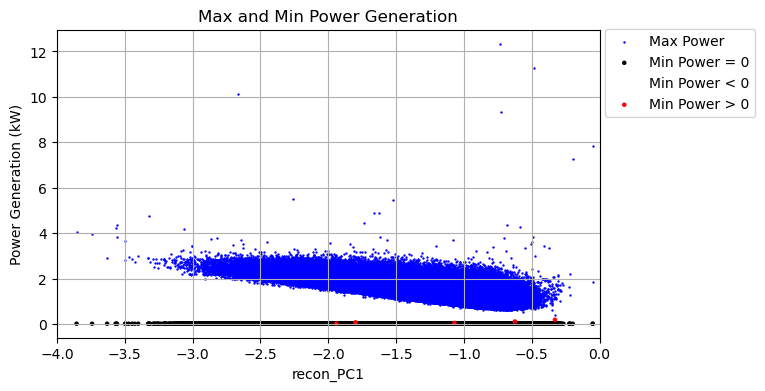

In [39]:
# Plot the maximum and minimum power_kW values for curves where PC1 < -10
print("Number of data points extracted", len(pc_df))
plot_min_max(pc_df,
             x_axis = "recon_PC1",
             main_scatter_size = 0.5)

plt.xlim([-4, 0])

# plt.savefig("maxmin_power_pc1fixed.png")

In [30]:
df_meta.describe()
Q1 = df_meta["kwp"].quantile(0.25)
Q3 = df_meta["kwp"].quantile(0.75)

df_meta2 = df_meta[(df_meta["kwp"] >= Q1) & (df_meta["kwp"] <= Q3)]
df_meta2

,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at
0,2405,53.53,-1.63,E01007430,180.0,35.0,3.36,2010-11-18
23,2428,53.46,-1.46,E01007891,180.0,30.0,3.36,2010-12-20
34,2439,51.06,-1.30,E01023258,150.0,45.0,2.88,2010-12-20
49,2454,51.06,-1.30,E01023258,215.0,45.0,2.52,2011-01-21
53,2458,51.06,-1.30,E01023258,135.0,45.0,2.34,2011-01-21
...,...,...,...,...,...,...,...,...
24289,26760,56.12,-3.93,S00133232,185.0,30.0,3.27,2016-11-17
24290,26761,56.12,-3.93,S00133232,185.0,30.0,3.27,2016-11-17
24291,26762,55.78,-2.35,S00095532,230.0,44.0,2.50,2016-11-17
24293,26764,55.93,-3.14,S00106643,170.0,30.0,2.55,2016-11-17


In [31]:
pca_outliers = pca_outliers.merge(df_meta2, on="ss_id", how="inner")

pca_outliers.describe()

,id,ss_id,recon_PC1,recon_PC2,power_PC1,power_PC2,latitude_rounded,longitude_rounded,orientation,tilt,kwp
count,1.000000e+01,10.000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,4.750236e+11,7539.400,5496.774820,30976.035439,-14088.071615,-8410.830616,56.172000,-4.504000,202.500000,41.100000,2.902000
std,2.731440e+11,1900.577,68901.884399,44692.617705,40050.685217,19126.657622,0.534349,0.860119,27.613403,12.332883,0.206656
min,3.435990e+10,3148.000,-114966.087819,-2253.228546,-70758.107690,-37581.017937,55.980000,-4.910000,135.000000,6.000000,2.500000
25%,2.877630e+11,7635.000,-20364.103436,5209.908377,-46124.249646,-18515.359513,55.980000,-4.910000,205.000000,45.000000,3.000000
50%,4.638568e+11,7635.000,-833.141763,9724.907518,-9257.837287,-8525.582759,55.980000,-4.910000,205.000000,45.000000,3.000000
75%,6.914899e+11,7635.000,19360.011776,46525.936412,3133.626609,3136.055824,55.980000,-4.910000,205.000000,45.000000,3.000000
max,8.160442e+11,11166.000,123025.026371,143950.881234,57048.260985,23766.557808,57.680000,-2.700000,250.000000,45.000000,3.000000


In [ ]:
# Save the main cluster (with no major anomalies) for further anomaly detection
# df.where((F.col("recon_PC1") <= 100) & (F.col("recon_PC1") >= -100)) \
#   .repartition(1).write.parquet("preprocessed_df_subset")